# Econometrics-3, section 4:
# Optimization, NLLS, conditional MLE

*Kirill Perminov, New Economic School, 2022*

*augmented by Tatul Ayrapetyan, 2024*

## Load libraries

In [1]:
import numpy as np
import scipy.stats
from scipy.optimize import minimize, least_squares
import matplotlib.pyplot as plt

## Simulate data for NLLS and conditional MLE

Exam, $n$ problems. Consider the following model:
* $\beta_0$ is the probability that you choose the right approach
* $\beta_1$ is the probability of making an arithmetic mistake
* If you spend $x$ additional minutes, the mistake is detected and corrected with probability $(1 - e^{-\beta_2 x})$

Let $y_i = \begin{cases} 1, \quad&\text{if problem $i$ is solved,} \\ 0, \quad&\text{otherwise.} \end{cases}$

Then:
$$ E[y|x] = P[\text{problem $i$ is solved}|x] = \beta_0 (1 - \beta_1 e^{-\beta_2 x}) $$

Let's generate $\{(x_i, y_i)\}_{i=1}^n$:

In [2]:
def get_y_proba(x, b): # (n,)
    return b[0] * (1 - b[1] * np.exp(-b[2] * x))

def get_y_proba_grad(x, b): # (n, 3)
    return np.array([
        1 - b[1] * np.exp(-b[2] * x),
        -b[0] * np.exp(-b[2] * x),
        b[0] * b[1] * x * np.exp(-b[2] * x)
    ]).T

beta = np.array([0.8, 0.4, 1])
xdist = scipy.stats.gamma(a=4, scale=0.5)
n = 100

x = xdist.rvs(size=n)
y = scipy.stats.bernoulli.rvs(p=get_y_proba(x, beta))

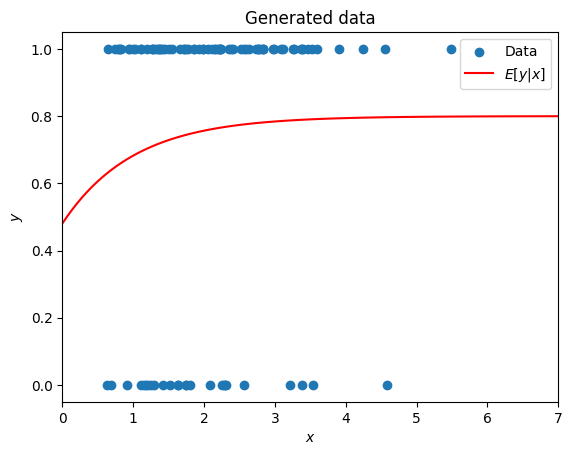

In [3]:
plt.scatter(x, y, label='Data')
grid = np.linspace(0, 7, 101)
plt.plot(grid, get_y_proba(grid, beta), color='red', label='$E[y|x]$')
plt.title('Generated data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(left=grid[0], right=grid[-1])
plt.legend()
plt.show()

## Concentration method

Rewrite the model as: 

$$
E[y|x]=g(x,\beta)=\beta_0-\beta_1'e^{-\beta_2x}
$$

Where $\beta_1'=\beta_0\cdot \beta_1$. Note that the initial parameter of $\beta_1$ is still identified unless $\beta_0=0$ or $\beta_2=0$, since you can simply compute the estimates as $\hat{\beta}_1=\frac{\hat{\beta}_1'}{\hat{\beta_0}}$. 

Now, to implement concentration method, we need to set up some grid for $\beta_2$:

In [4]:
b2_grid=np.linspace(0.01,10,1000)

In what follows, we just need to compute estimates of $\beta_0$ and $\beta_1$ as a regular LS estimation; then we will choose the value in the grid that gives best value of the LS function. 

In [5]:
# Store values of coefficients and least squares estimate
b0_val=np.zeros(len(b2_grid))
b1_val=np.zeros(len(b2_grid))
LS=np.zeros(len(b2_grid))


# Compute OLS for each value of beta_2
for i in range(len(b2_grid)):
    b2=b2_grid[i] # just notation for the running value of beta_2
    X_=-np.exp(-b2*x) # quasiregressor
    ones=np.ones(len(x)) # intercept
    X=np.array((ones,X_)).T # matrix of quasiregressor values 
    b0,b1= np.linalg.inv(X.T@X)@X.T@y # OLS estimates
    b0_val[i]=b0 
    b1_val[i]=b1/b0 # storing parameter values
    LS[i]=np.sum((y-b0-b1*X_)**2) # storing least squares values


Now the second step – find the optimal value of $\beta_2$ among the computed least squares values. 

In [10]:
ind=np.argmin(LS)
beta_0=b0_val[ind]
beta_1=b1_val[ind]
beta_2=b2_grid[ind]

print(f'beta[{0}]: {beta_0:.2f}')
print(f'beta[{1}]: {beta_1:.2f}')
print(f'beta[{2}]: {beta_2:.2f}')


beta[0]: 0.91
beta[1]: 0.39
beta[2]: 0.38


## NLLS

Once again:
$$ E[y|x] = g(x, \beta) = \beta_0 (1 - \beta_1 e^{-\beta_2 x}) $$

We can run nonlinear mean regression to estimate $\beta$. All we need is a function that computes residuals: $(y - g(x, b))$ for a given $b$.

Our friend `scipy.optimize.least_squares` will do the rest.

In [50]:
def get_residuals(b): # (n,)
    return y - get_y_proba(x, b)

def get_residuals_jac(b): # (n, 3)
    return -get_y_proba_grad(x, b)

result = least_squares(
    fun=get_residuals,
    x0=np.array([0.5, 0.5, 1]),
    jac=get_residuals_jac,
    bounds=((0, 0, 0), (1, 1, np.inf)),
)

In [51]:
result

 active_mask: array([0, 0, 0])
        cost: 7.324597524439826
         fun: array([ 0.10063524, -0.92178336,  0.23525581, -0.86604267,  0.11551162,
       -0.62982809, -0.80917005,  0.11242615,  0.22951753,  0.1617631 ,
        0.11682721,  0.34977091,  0.09946065,  0.20832698,  0.15763103,
        0.17390382,  0.1268915 ,  0.12887871,  0.24680145,  0.24408583,
        0.15201445,  0.19894468,  0.16629852,  0.22578764,  0.09327719,
        0.2427209 , -0.64191778,  0.14201477,  0.28829927,  0.14073195,
        0.2327269 ,  0.27752511,  0.11794426,  0.14669591,  0.19720018,
        0.15160533,  0.07688592, -0.73190141,  0.09484011, -0.85251741,
       -0.69480158, -0.66983739,  0.27501873,  0.07513352,  0.12072642,
        0.21565725, -0.74374423,  0.15330931,  0.16842984,  0.23563778,
       -0.70090351,  0.09880798,  0.29568166, -0.89251929,  0.29179082,
        0.26640096,  0.0798883 , -0.7281179 ,  0.20281702,  0.48959919,
        0.15168465,  0.18004777,  0.07100004,  0.21110055, 

In [52]:
beta_hat = result.x
beta_hat

array([0.93027116, 0.56046479, 0.93781592])

Compute standard errors using OLS formilas and the notion of a quasi-regressor:
$$ g_\beta(x, b) = \frac{\partial g(x, b)}{\partial b}, \quad Q_{gg} = E[g_\beta(x, \beta) g_\beta(x, \beta)'], \quad V_{ge} = \text{Var}[g_\beta  e] = E[g_\beta  g_\beta' e^2] $$
$$ V_\beta = Q_{gg}^{-1} V_{ge} Q_{gg}^{-1} $$

In [53]:
X_quasi = get_y_proba_grad(x, beta_hat) # (n, 3)
Qgg_hat = X_quasi.T @ X_quasi / n # (3, 3)
Qgg_hat_inv = np.linalg.inv(Qgg_hat) # (3, 3)
e_hat = get_residuals(beta_hat) # (n,)
Vge_hat = X_quasi.T @ (X_quasi * (e_hat ** 2)[:, np.newaxis]) / n # (3, 3)
Vbeta_hat = Qgg_hat_inv @ Vge_hat @ Qgg_hat_inv # (3, 3)

In [54]:
for i in range(beta.shape[0]):
    print(f'beta[{i}]: {beta_hat[i]:.3f} +- {np.sqrt(Vbeta_hat[i][i] / n):.3f}')

beta[0]: 0.930 +- 0.114
beta[1]: 0.560 +- 0.437
beta[2]: 0.938 +- 1.035


## Conditional MLE

Conditional distribution:
$$ P(y=y_i | x=x_i) = \begin{cases}
\beta_0 (1 - \beta_1 e^{-\beta_2 x_i}), \quad&\text{if } y_i = 1, \\
1-\beta_0 (1 - \beta_1 e^{-\beta_2 x_i}), \quad&\text{if } y_i = 0.
\end{cases} $$

Or, alternatively:
$$ P(y=y_i | x=x_i) = \big(\beta_0 (1 - \beta_1 e^{-\beta_2 x_i})\big)^{y_i} \big(1-\beta_0 (1 - \beta_1 e^{-\beta_2 x_i})\big)^{1-y_i} $$

Loglikelihood function:
$$ \ell_n = \sum_{i=1}^n \Big[ y_i \log\big(\beta_0 (1 - \beta_1 e^{-\beta_2 x_i})\big) + (1-y_i) \log \big(1-\beta_0 (1 - \beta_1 e^{-\beta_2 x_i})\big) \Big] $$

I know it sounds weird, but loglikelihood can be maximized using ```scipy.optimize.minimize```:

In [55]:
def get_logl(x, b): # (n,)
    return y * np.log(get_y_proba(x, b)) + (1 - y) * np.log(1 - get_y_proba(x, b))

def get_score(x, b): # (n, 3)
    p = get_y_proba(x, b)
    return (y / p - (1 - y) / (1 - p))[:, np.newaxis] * get_y_proba_grad(x, b)

def get_logl_neg(b): # scalar
    return -np.sum(get_logl(x, b))

def get_logl_neg_jac(b): # (3,)
    return -np.sum(get_score(x, b), axis=0)

result = minimize(
    fun=get_logl_neg,
    x0=np.array([0.5, 0.5, 1]),
    jac=get_logl_neg_jac,
    bounds=[(0, 1), (0, 1), (0, np.inf)]
)

In [56]:
result

      fun: 46.32883183085179
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.28793297e-05,  1.71263564e-05, -2.72247311e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([0.91326629, 0.60165442, 1.10675885])

In [57]:
beta_hat = result.x
score = get_score(x, beta_hat)
I = score.T @ score / n
Vbeta_hat = np.linalg.inv(I)

for i in range(beta.shape[0]):
    print(f'beta[{i}]: {beta_hat[i]:.3f} +- {np.sqrt(Vbeta_hat[i][i] / n):.3f}')

beta[0]: 0.913 +- 0.088
beta[1]: 0.602 +- 0.493
beta[2]: 1.107 +- 1.117
